# Text Extraction from Images - Using OCR Tool (tesseract)

In this notebook, We will try to learn text extraction from images using [Tesseract](https://pypi.org/project/pytesseract/) library & then perform sentiment analysis on the extracted text.

**Brief Intro** : Python-tesseract is an optical character recognition (OCR) tool for python. That is, it will recognize and “read” the text embedded in images. For more details please read from the link above.

Does it sound interesting to you? If so, then don't forget to UPVOTE. So, let's get started !!

## Libraries

In [ ]:
# Generic Libraries
from PIL import Image
import os
import pandas as pd
import numpy as np
import re,string,unicodedata

#Tesseract Library
import pytesseract

#Warnings
import warnings
warnings.filterwarnings("ignore")

#Garbage Collection
import gc

#Gensim Library for Text Processing
import gensim.parsing.preprocessing as gsp
from gensim import utils

#TextBlob Library (Sentiment Analysis)
from textblob import TextBlob, Word

#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#WordCloud Generator
from wordcloud import WordCloud,STOPWORDS

## Some Exploration

In [ ]:
#Define Directory Path
sample_images = '../input/detecting-sentiments-dataset/Sample Data Files/'

In [ ]:
test_images = '/kaggle/input/falafel/Labelled Images/'

In [ ]:
#Custom Function to Traverse the folder
def traverse(directory):
    path, dirs, files = next(os.walk(directory))
    fol_nm = os.path.split(os.path.dirname(path))[-1]
    print(f'Number of files found in "{fol_nm}" : ',len(files))

In [ ]:
#Traversing the folders
traverse(sample_images)
traverse(test_images)

Number of files found in "Sample Data Files" :  3
Number of files found in "Labelled Images" :  749


## Extracting Text (the fun stuff !)

In [ ]:
ex_txt = []   #list to store the extracted text

#Function to Extract Text
def TxtExtract(directory):
    """
    This function will handle the core OCR processing of images.
    """
    
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            filepath = subdir + os.sep + file
            text = pytesseract.image_to_string(Image.open(filepath), timeout=5)
            if not text:
                ex_txt.extend([[file, "blank"]])
            else:   
                ex_txt.extend([[file, text]])
                
    fol_nm = os.path.split(os.path.dirname(subdir))[-1]
    
    print(f"Text Extracted from the files in '{fol_nm}' folder & saved to list..")

In [ ]:
#Extracting Text from JPG files in Sample Image Folder
TxtExtract(sample_images)

#Extracting Text from JPG files in Dataset Folder
TxtExtract(test_images)

Text Extracted from the files in 'Sample Data Files' folder & saved to list..
Text Extracted from the files in 'Labelled Images' folder & saved to list..


In [ ]:
#Converting the list to dataframe for further analysis
ext_df = pd.DataFrame(ex_txt,columns=['FileName','Text'])

In [ ]:
#Inspect the dataframe
ext_df.head()

,FileName,Text
0,Sample_Positive.jpg,
1,Sample_Random.jpg,
2,Sample_Negative.jpg,Of course gay men\n\ndress well. They didn't\n...
3,CVf4HDmWcAE_Q4m.png,Bernie Sanders @BernieSanders « 10h\nsy how do...
4,1JQk5NF.png,\n


In [ ]:
print("Total Records: ", ext_df.shape[0])

Total Records:  752


## Extracted Text Processing

In [ ]:
# Create list of pre-processing func (gensim)
processes = [
               gsp.strip_tags, 
               gsp.strip_punctuation,
               gsp.strip_multiple_whitespaces,
               gsp.strip_numeric,
               gsp.remove_stopwords, 
               gsp.strip_short, 
               gsp.stem_text
            ]

# Create func to pre-process text
def proc_txt(txt):
    text = txt.lower()
    text = utils.to_unicode(text)
    for p in processes:
        text = p(text)
    return text

In [ ]:
#Creating a new column with processed text
ext_df['Text_Pr'] = ext_df['Text'].apply(lambda x: proc_txt(x))

In [ ]:
#Creating a seperate dataframe with non-blank Text 
ext_df_txt = ext_df[(  ext_df['Text_Pr'] != 'blank'  )]

In [ ]:
print("Total Records in Text Only Dataframe: ", ext_df_txt.shape[0])

Total Records in Text Only Dataframe:  752


## Sentiment Analysis

In [ ]:
# Creating a function to analyse the tweet sentiments

def sentiment_analyzer(text):
    TB_sentiment_polarity = TextBlob(text).sentiment.polarity
    
    # decide sentiment as positive, negative and neutral 
    if TB_sentiment_polarity >= 0.00 : 
        return "Positive" 
  
    elif TB_sentiment_polarity <= 0.00 : 
        return "Negative" 
  
    else : 
        return "Neutral"

In [ ]:
#Analysing the sentiment
ext_df_txt['Sentiment'] = ext_df_txt['Text_Pr'].apply(lambda x: sentiment_analyzer(x))

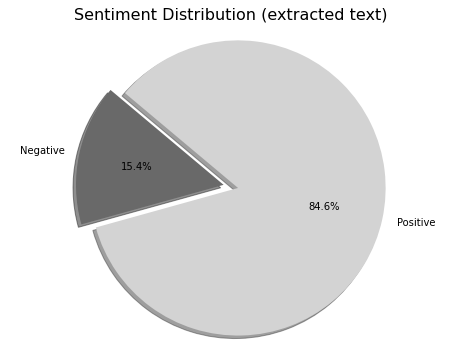

In [ ]:
sentiment_count = ext_df_txt.groupby('Sentiment').size()

# Data to plot
labels = 'Negative', 'Positive'
sizes = [sentiment_count[0], sentiment_count[1]]
colors = ['dimgrey', 'lightgray']
explode = (0.1, 0)  # explode 1st slice
fig = plt.figure(figsize=[8, 6])

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title("Sentiment Distribution (extracted text)", fontsize=16)
plt.show()

## Word Cloud

In [ ]:
# Function to plot word cloud
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(12.0,12.0), 
                   title = None, title_size=18, image_color=False):

    wordcloud = WordCloud(background_color='white',
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    
    if image_color:
        #image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'center'})
    plt.axis('off');
    plt.tight_layout()  


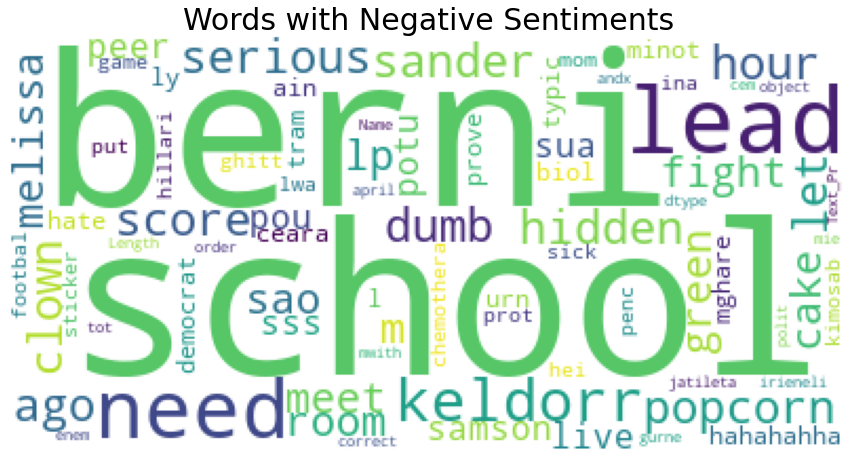

In [ ]:
txt = str( ext_df_txt[ext_df_txt['Sentiment'] == 'Negative'].Text_Pr )
plot_wordcloud(txt, max_words=200, max_font_size=100, 
               title = 'Words with Negative Sentiments', title_size=30)

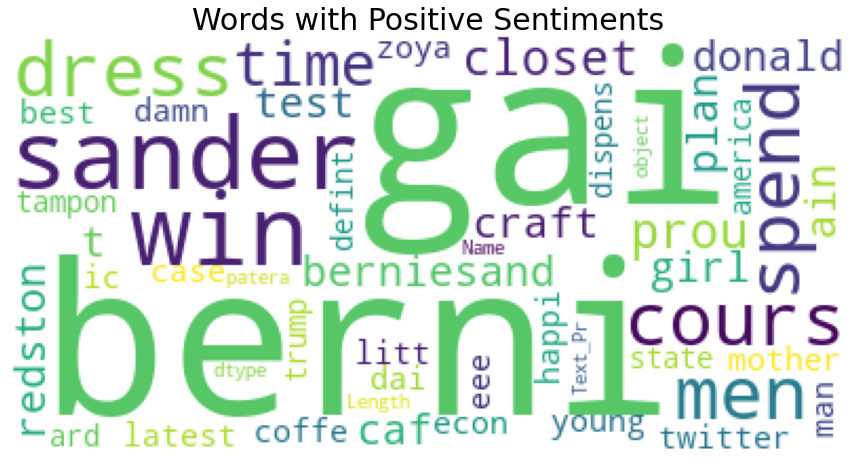

In [ ]:
txt = str( ext_df_txt[ext_df_txt['Sentiment'] == 'Positive'].Text_Pr )
plot_wordcloud(txt, max_words=200, max_font_size=100, 
               title = 'Words with Positive Sentiments', title_size=30)

In [ ]:
#Free up memory
gc.collect()

8804